<a href="https://colab.research.google.com/github/nklsKrmnn/LSC_Sentiment_Analysis/blob/main/Projekt_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/LSC_Sentiment_Analysis'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/LSC_Sentiment_Analysis


In [ ]:
import numpy as np
import seaborn as sns

try:
  import json
except:
  %pip install -q json
  import json

try:
  import logging
except:
  %pip install -q logging
  import logging

try:
  import sys
except:
  %pip install -q sys
  import sys

try:
  import os
except:
  %pip install -q os
  import os

try:
  import pandas as pd
except:
  %pip install -q pandas
  import pandas as pd

try:
  import torch
  from torch.utils.data import DataLoader
  import torch.nn as nn
  import torch.optim as optim
  from torchsummary import summary
except:
  %pip install -q torch
  import torch
  from torch.utils.data import DataLoader
  import torch.nn as nn
  import torch.optim as optim
  from torchsummary import summary

try:
  from sklearn.model_selection import train_test_split
except:
  %pip install -q sklearn
  from sklearn.model_selection import train_test_split

try:
  import transformers
  from transformers import BertTokenizer, BertModel, BertConfig
except:
  %pip install -q transformers
  import transformers
from transformers import BertTokenizer, BertModel, BertConfig

from evaluation_bert import test_bert
from data.datasets import dataset
from main import load_json
from evaluation import test_statistics



# 1. Theorie BERT

Das Acronym BERT steht für "**B**idirectional **E**ncoder **R**epresentations from **T**ransformers" und ist eine Netzwerk-Architektur, die von der Google Tochter DeepMind entwickelt und publiziert wurde. [1]

## 1.1 Modellarchitektur

 Die Architektur ist ein multi-layer bidirektionaler Tranformer-Encoder basierend auf der implementation von Vaswani et al. [2]. Die Architektur eines Tranformers wurde in dem Kurzvortrag "Attention is all you need" in der Vorlesung vorgestellt und soll daher hier, abgesehen von dem für uns relenvanten Encoder-Block, nicht weiter ausgeführt werden. Der Encoder ist ein Block, der aus einem multi-head Self-Attention-Layer und einem simplen Feed Forward Netzwerk. Außerdem wird nach jedem Layer normalisiert und die Inputs des Layers aufaddiert, wie bei einem Residual-Layer. Diese Architekur ist
 unten in dem Origialbild aus dem Paper visualisiert.

# 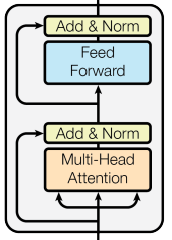


 Der Self-Attention-Mechanismus ist eine wichtige Entwicklung im Bereich des Natural Language Processing, die durch den Einsatz in der Transformer Architektur aus dem Paper "Attention is all you need" hohe Aufmerksamkeit in der Machine Learning-Community erlangt hat. In einem Self-Attention Layer werden aus der tokenisierten und embeddeten Inputsequenz die 'Values' der Tokens gewichtet durch das Produkt aus 'Queries' und 'Keys' der Tokens addiert. Die 'Values', 'Queries' und 'Keys' sind Matrizten, die über gelernte Gewichtsmatrizen aus der Inputsequenz berechnet werden. [3] Die Grundidee dabei ist, dass die 'Key' und die 'Queries' die Wichtigkeit verschiedener Tokens in der Sequenz erkennen und die 'Values' jeweils einen Wert der dort stehenden Tokens repräsentieren.

Die Innovation, die Google mit dem BERT-Modell, geschaffen hat, liegt dabei im Pre-Training des Modells. Die klassischen Tranformer werden durch die Prediktion des Folgewortes einer Inputsequenz trainiert. Dem entsprechend ist zur Berechnung des 'Values' die 'Values' der Folgeworte maskiert. Man spricht dabei von einer left-to-right-Architektur, weil der Algorithmus wie ein Mensch den Text von links nach rechts 'ließt'. Das BERT-Modell setzt im Gegensatz dazu auf einen bidirektionalen Ansatz. Das heißt, dass die nachfolgenden Wörter zur Berechnung der 'Values' nicht maskiert werden. Beim Training werden daher nur einzelne zufällige Wörte im Text maskiert, die dann prediziert werden. Als zweite Trainingsaufgabe werden dem Netzwerk zwei Sätze präsentiert und das Netzwerk muss entscheiden, ob der zweite Satz auf den ersten Satz folgen kann oder ob die beiden Sätze hintereinander keinen Sinn ergeben. Aufgrund dieses Trainingsansatzes ist das Netzwerk gut geeignet zur Extraktion des Kontextes bzw. des Iahaltes eines Textes, jedoch weniger, um künstliche Texte zu generieren. [3]

Da Sentiment Analyse eine Art der Klassifikation des Inhaltes von Texten ist, haben wir uns dazu entschieden für diese Projekt ein BERT-Modell als Large Language Model einzusetzen.


# 1.2 Fine-Tuning

Fine-Tuning bezeichnet Anpassen von vortrainierten Modellen auf den eigenen spezifischen Anwendungsfalls. In diesem Fall ist der BERT Modell auf allgemeinen Texten und mit der oben beschriebenen Methodik vortrainiert. Um das Modell auf unsere Sentiment Analyse anwenden zu können muss zum einen die Architektur entsprechen angepasst werden und die Parameter müssen in der spezifischen Domäne nachtrainiert werden.

Laut den Authoren von DeepMind ist zur Anpassung der Architektur nichts weiter nötig, als das anhängen eines Aufgabenspezifischen Layers.

# 2. Vorgehen bei Experimenten

Um eine Vielzahl an verschiedenen Ansätzen ausprobieren zu können haben wir eine Programmstruktur aufgebaut, die es uns erlaubt hat, trotz einer Vielzahl von Versuchen das Vorgehen zu standardisieren. Da Dies unser erstes umfangreiches Projekt zu diesem Thema ist, hat das Schaffen dieser Struktur alleine schon relativ viel Zeit in Anspruch genommen und ist für uns neben den Ergebnissen der Experimente ein wichtiger Outcome dieses Projektes. Daher soll dies in diesem Abschnitt ebenfalls erläutert werden.

## 2.1 Training Neuronaler Netze

Wie in der Vorlesung behandelt, wird beim Trainieren von Neuronalen Netzen über mehrere Epochen der gesamte Trainingsdatensatz durch das Modell propagiert, der Fehler über eine Loss-Funktion berechnet und auf Basis dieses Losses die Parameter des Netzes über die Backpropagation optimiert. Bei großen Daten ist es üblich, dabei pro Epoch den Datensatz zufällig in sogenannte Batches zu unterteilen. Jede Batch wird dann einzeln vorwärts und rückwerts propagiert. Der Grund für dieses Vorgehen ist, dass auf Grund von Hardware Limitationen oft nicht der gesamte Datensatz auf einmal verarbeitet werden kann. Wir haben dieses Vorgehen in einer Klasse *nettrainer* realisiert, der alle relevanten Trainingsparameter übergeben werden, wie zum Beispiel Batchsize, das zu trainierende Modell oder das Hardware-Device auf dem trainiert werden soll.

Nach jeder Epoche wird außerdem das Validation-Set einmal durch das Netzwerk propagiert und der Loss sowie die Accuracy berechnet. Die Loss-Funktion wird ebenfalls dem *nettrainer* übergeben. Den Validation-Loss und den Trainings-Loss zu beobachten ist wichtig, um Overfitting im Training zu erkennen. Sinkt der Trainings-Loss im Laufe der Epochen, während der Validation-Loss aber steigt, ist die ein klares Zeichen für Overfitting. Das Modell funktioniert dann auf den Trainingsdaten besser als auf ungesehenen Daten.

## 2.2 Handhabung der Daten im Training

Zur Implementierung des Trainings wir überwiegend die vordefinierten Klassen von Pytorch genutzt, zur Datenhandhabung im speziellen die Dataset- und die Dataloader-Klasse. Die Datalaoder-Klasse ermöglich das ziehen von Batches aus einem Dataset, dass der Klasse übergeben wird. Die Dataset-Klasse ermöglicht den Zugriff auf die Samples (bei Torch: 'Items') über einen Index. Wir haben bei der Implementierung der Dataset-Superklasse außerdem eingebaut, dass bei setzen entprechender Variablen die Inputs des Items tokenized oder/und die Target-Labels onehot-encoded werden. Dies ermöglicht es, mit der selben Klasse verschiedene Datensätze (wie bei uns Movie-Reviews und Twitter) für verschiedene Netzwerk-Architekturen zu verarbeiten.

Wie bereits im Notebook zur Voranalyse der Daten beschrieben, sind wir bei den ersten Versuchen, das Netz auf der CPU unserer Rechner zu trainieren, an die Grenzen unserer Hardware gestoßen. Speziell hat der RAM nicht ausgereicht, um das Training zu starten. Daher haben wir auf 6 getrennten Datensätzen trainiert. Um dies zu zu ermöglichen wird erst beim starten des Trainings im *Nettrainer* der Datensatz mit der Dataset- und Dataloader-Klasse geladen. Optional kann man dem *Nettrainer* über eine Variable den gesamten Trainingsdatensatz zu Beginn des Trainings oder rundum einen der 6 Datensätze pro Epoche laden lassen.

## 2.3 Training-Hyperparameter-Management

Bei beim Training von Neuronalen Netzen gibt es eine Vielzahl von Hyperparametern, die man variieren kann, um ein möglichst gutes Ergebnis zu erzielen. Diese Parameter umfassen Parameter für das Training, von denen oben bereits einige genannt wurde, aber auch Parameter, wie die Datenaufbereitet werden und wie das Netzgestaltet ist. Da für uns ein Lernziel dieses Projektes war, ein Gefühl dafür zu bekommen, wie sich welche Parameter auf das Trainingsverhalten auswirken, haben wir das Hyperparameter-Tuning nicht automatisiert, sondern manuell gemacht. Um trotzdem den Überblick zu behalten defurfte es einen System zur Steuerung dieser Parameter. Dazu haben wir eine JSON-Datei angelegt, in der alle einstellbaren Parameter hinterlegt werden und die dann in unserer main() eingelesen wird und aus der die Parameter an entsprechender Stelle im Programm ablauf eingelesen werden. Unten ist exemplarisch eine solche JSON-Datei abgebildet.

In [ ]:
"""
 {
    "name": "PPBERT_2Res_do3_MSE--bs45--adam",
    "model_type": "MLP",
    "model_path": "",
    "data_dir": "dataset_mr_after_first_layer_notOH",
    "batchsize_train": 100,
    "batchsize_val": 200,
    "batchsize_test": 200,
    "epochs": 1500,
    "n_trainsets": 6,
    "start_trainset": -1,
    "freeze_first": false,
    "inflation": 10,
    "patience": 0,
    "validation_size": 0.2,
    "learning_rate": 0.03,
    "momentum": 0.5,
    "gpu": true,
    "seed": 42,
    "translateV_chance": 0.5,
    "channels": 1,
    "criterion": "mse",
    "optimizer": "adam",
    "onehot": false,
    "tokenize": true,
    "max_len": 200
}
"""

'\n {\n    "name": "PPBERT_2Res_do3_MSE--bs45--adam",\n    "model_type": "MLP",\n    "model_path": "",\n    "data_dir": "dataset_mr_after_first_layer_notOH",\n    "batchsize_train": 100,\n    "batchsize_val": 200,\n    "batchsize_test": 200,\n    "epochs": 1500,\n    "n_trainsets": 6,\n    "start_trainset": -1,\n    "freeze_first": false,\n    "inflation": 10,\n    "patience": 0,\n    "validation_size": 0.2,\n    "learning_rate": 0.03,\n    "momentum": 0.5,\n    "gpu": true,\n    "seed": 42,\n    "translateV_chance": 0.5,\n    "channels": 1,\n    "criterion": "mse",\n    "optimizer": "adam",\n    "onehot": false,\n    "tokenize": true,\n    "max_len": 200\n}\n'

## 2.4 Trainingsmonitoring

Neben dem Management der Parameter ist es bei der manuellen Arbeit mit Neuronalen Netzen auch wichtig, die Trainingsergebnisse systematisch zu dokumentieren. Diese haben wir mit Hilfe von Tensorbaord gemacht. Tensorboard ist ein Modul von Tensorflow, das es ermöglicht verschiedene Werte aus einem Trainingsablauf zu tracken und anschließend in einer benutzerfreundlichen Web-Anwendung darzustellen. Dazu haben wir ein Logger-Klasse geschrieben, die mit dem Summary-Writer von Pytorch arbeitet. Wir haben mit dem Logger folgende Parameter getrackt:

*   Parameter-Setting aus JSON-Datei
*   Startzeitpunkt
*   Endzeitpunkt
*   Trainingsdauer
*   Grund für Trainingsende
*   Trainings- und Validation-Loss pro Epoche
*   Accuracy pro Epoche
*   Aufbau des genutzten Netzes



# 3. Trainingsergebnisse

## 3.1. Erster Versuch: Training gesamtes Modell

Bei den ersten Druchläufen mit dem Movie-Review-Dataset haben wir verschiedene Netzwerkarchitekturen als Klassifizier an den BERT-Layer angehängt und alle Parameter des Netzes inklusive des die des vortrainierten BERT-Layers optimiert. Zusammenfassend haben wir dabei die Erkenntnis erlangt, dass der Datensatz wahrscheinlich zu klein ist für so ein tiefes Netzwerk, da alle Versuche der Regularisierung fehlgeschlagen sind und es immer zum Overfitting gekommen ist. Im Folgenden sind ist ein Screenshot aus dem Tensorbaord zu sehen mit allen Trainingsversuchen in diesem Stadium. Weiter unten sind die verschiedenen Regularisierungsversuche detailliert erklärt mit einzelnen Grafiken zu den resultierenden Trainingsverläufen. 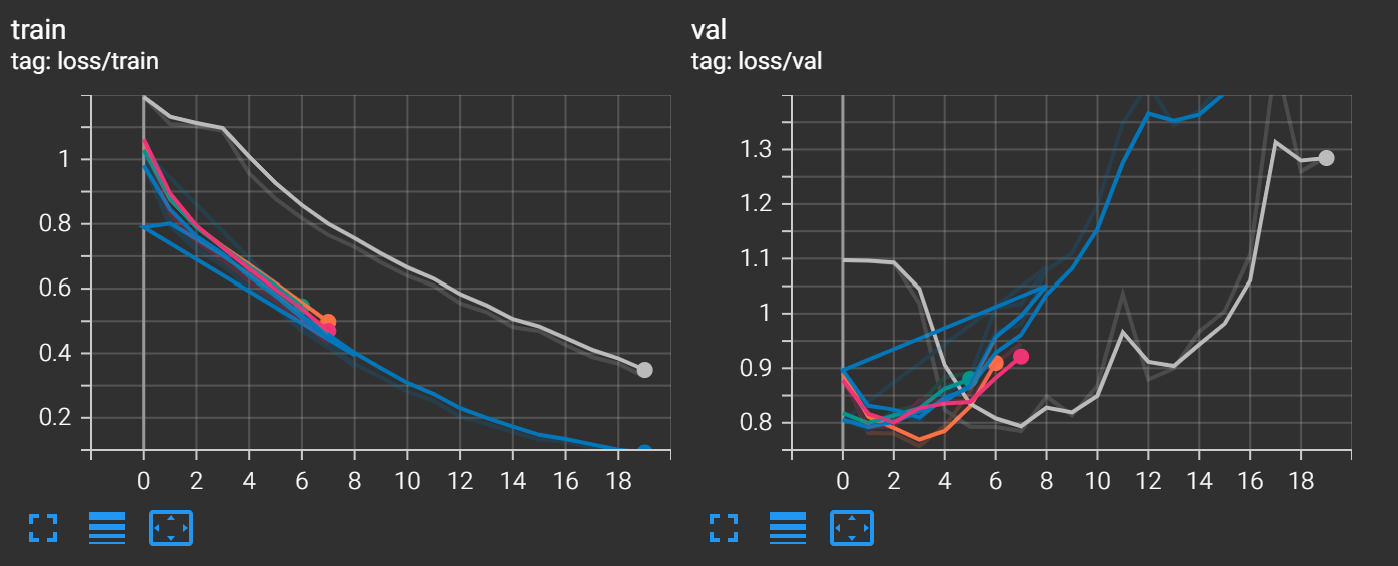

Man sieht in dieser Zusammenfassung bereits, dass bei allen Versuchen der Trainings-Loss sinkt, während der Validation-Loss nach kurzer Verbesserung schnell wieder ansteigt.

### 3.1.1 Simple Fully Connected Layer

Der erste Versuch war nach dem Vorschlag von einem Forum auf Hugging-Face, ein einfacher Fully Connected Layer und einem Dropout-Layer mit einer Dropout-Quote von 0.3. Der Fully Connected Layer nimmt als Input die 768 Knoten, die der BERT-Layer als Output generiert und erzeugt aus diesen wiederum 3 Outputs, die jeweils einer der Klassen -1 bis 1 zugeordnet sind. Entsprechend haben wir hier als Loss-Funktion den Softmax Crossentropy-Loss genutzt.

### 3.1.2 Zwei Fully Connected Layer

Als nächstes haben wir eine Klassifizierung mit 2 Fully Conntected Layern ausprobiert, den ersten mit 768, den zweiten mit 200 Input-Knoten. Sußerdem haben wir vor beiden Layern wieder einen Dropout-Layer mit einer Quote von 0.3 eingebaut. Dropout ist einer Regularisierungstechnik, bei der zufällig bei jedem Forward-Pass jeweils eine bestimmt Anzahl an Knoten komplett ausgeschaltet wird, unabhängig davon, ob diese durch vorherige Layer aktiviert wurden oder nicht. Dies erschwert es dem Netz Inhalte auswendig zu lernen, weil zufällig auch Knoten, die genau einen sprzifischen Inhalt repräsentieren wegfallen können. Durch die Verdoppelung der Anzahl der Dropout-Layer ergebt sich nur noch eine Durchlässigkeit von (1-0.3)^2 = 0.36, was eine Dropout-Quote von 0.64 ist. Da wir keine nicht-Linearität hinzugefügt haben, ist trotz des extra Layers keine erhöhte Komplexität abbildbar.

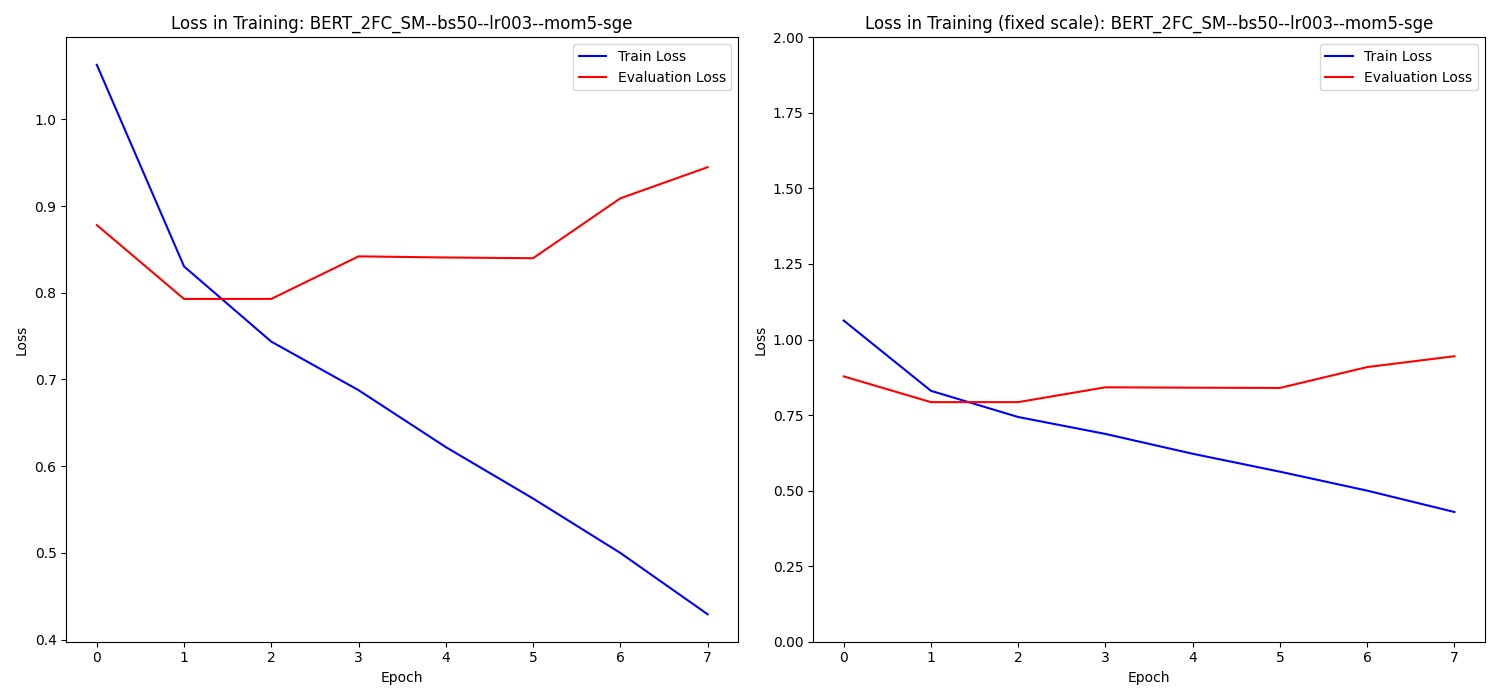

### 3.1.3 Erhöhung Dropout-Quote

In den folgenden beiden Versuchen haben wir die Dropout-Quote in beiden Dropout-Layern auf 0.7 und 0.9 erhöht, ohne, dass dieses Overfitting verhindert hätte.

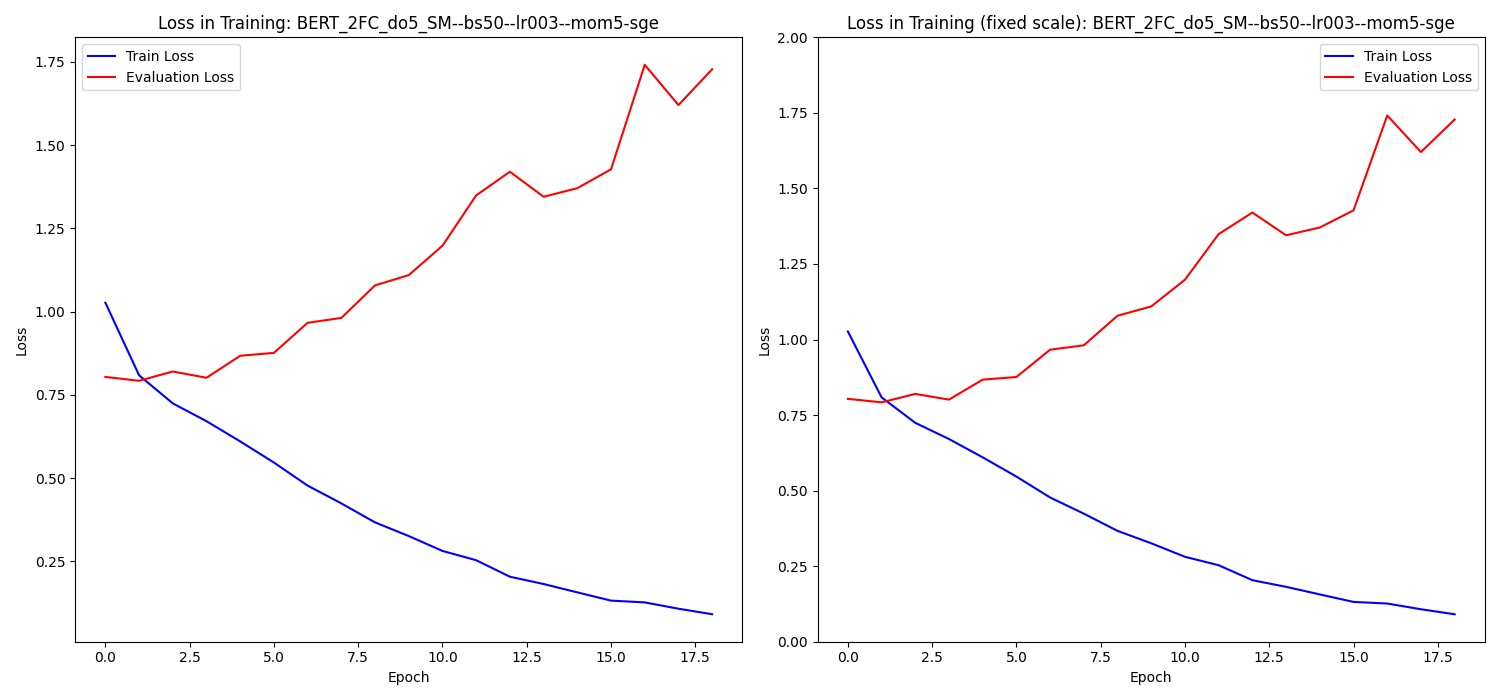

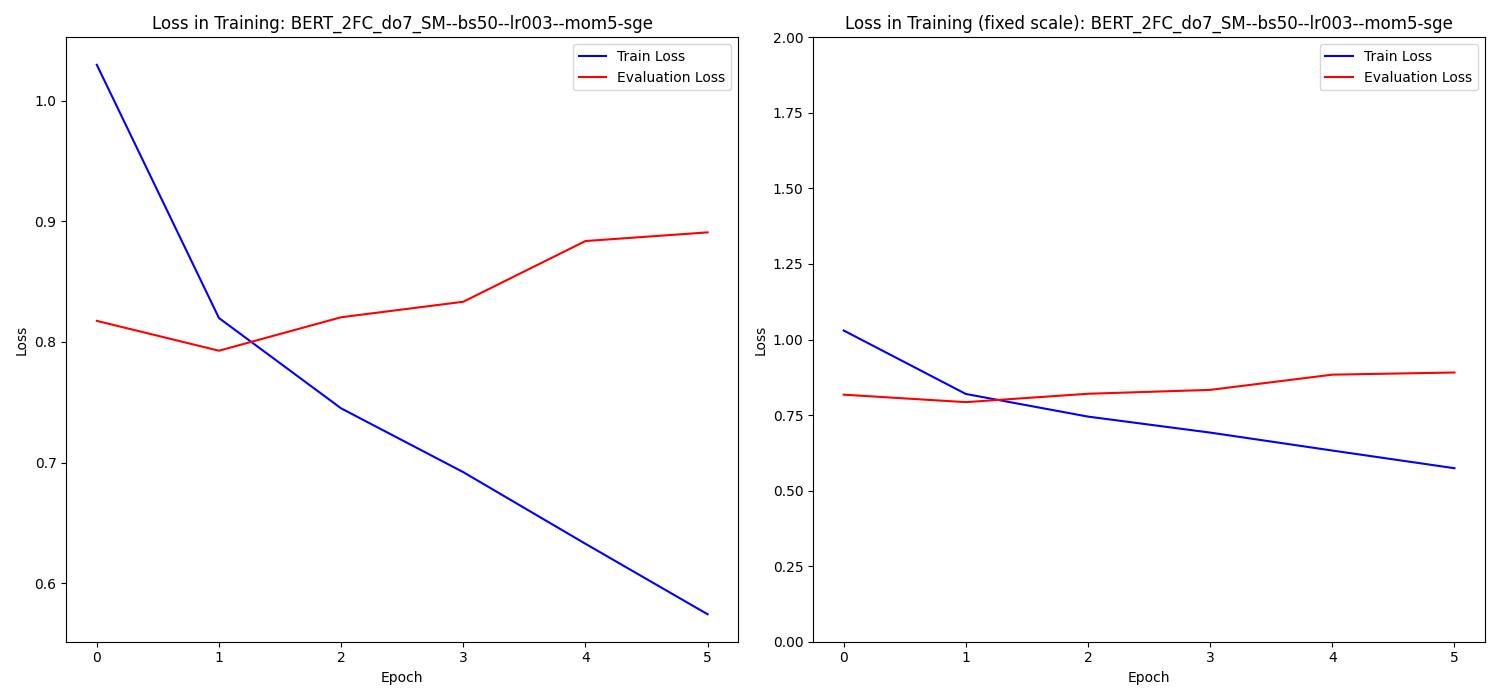

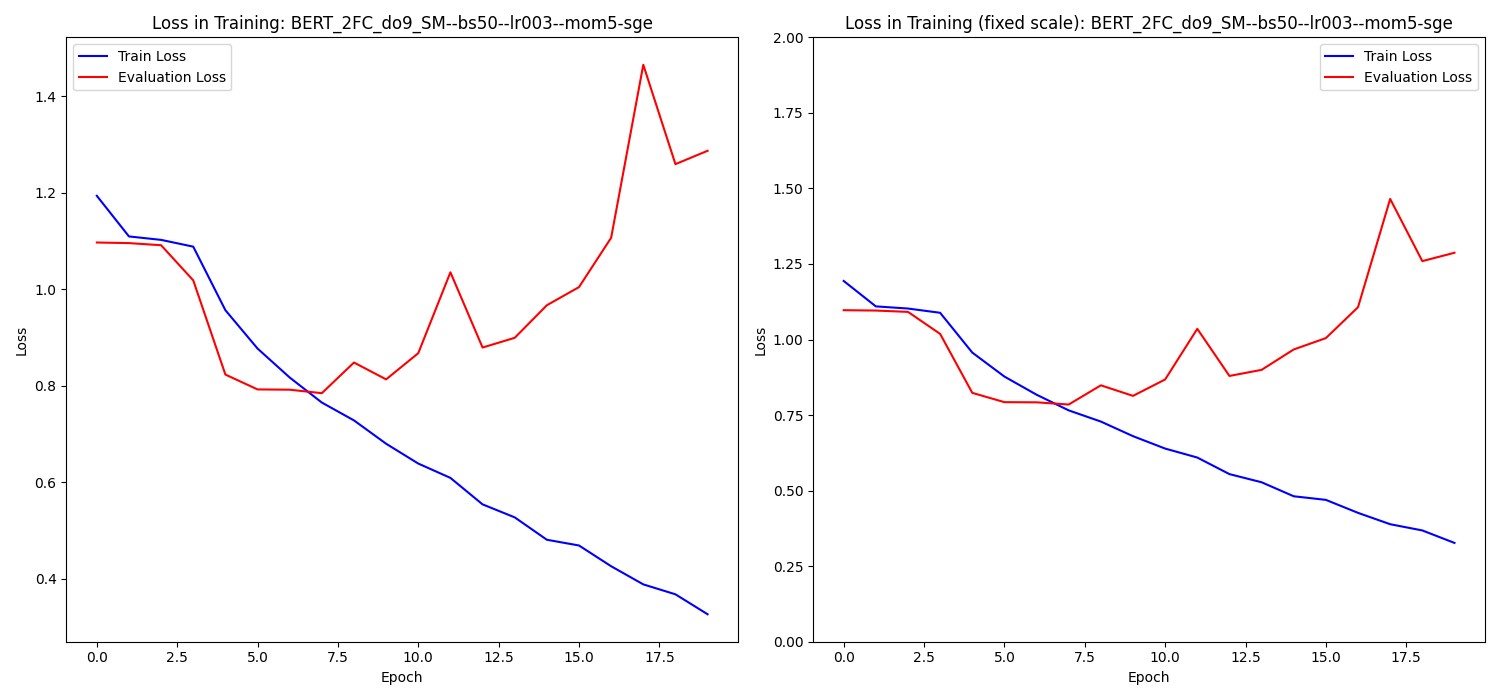

### 3.1.4 Batch-Normalisierung

Batchnormalisierung ist eine Methode zur Generalisierung, bei der in einem Zwischenlayer die Aktivierungen pro Knoten innerhalb einer Batch mit Hilfe von Z-Scaling normalisiert werden. Beim Z-Scaling werden Werte eines Features so transformiert, dass die Werte den Abstand zu ihrem Mittelwert abbilden, wobei eine Einheit einer Standardabwichung entspricht. Man geht hier also von einer Standardabweichung aus. Hinzu kommen bei der Anwendung von Z-Scaling zur Batch-Normalisierung, dass zwei lernbare Parameter delta und beta, die die Verteilung strecken bzw. stauchen oder und verschieben und somit die Normalisierung an die echte Verteilung anpassen können, da diese nicht immer einer Normalvertielung entspricht.



### 3.1.5 Residual Layer

Zu letzt haben wir einen Residual Layer ausprobiert. Bei einem Residual Layer werden die Inputs, die in einen oder mehrere Layerschichten übergeben werden, nach diesen Schichten auf den Output der Layer aufaddiert. Dadurch lernt der Layer nur die Abweichung von den Inputs und es fällt ihm einfacher, die Identität der Inputs zu lernen. Allerdings führt dies eher dazu, dass die tiefen Schichten besser lernen können, weil die Gradienten besser durch die Residual-Layer propagiert werden können. Von daher ist das Ergebnis, dass es auch hier zu einem Overfitting gekommen ist, nicht überraschen.

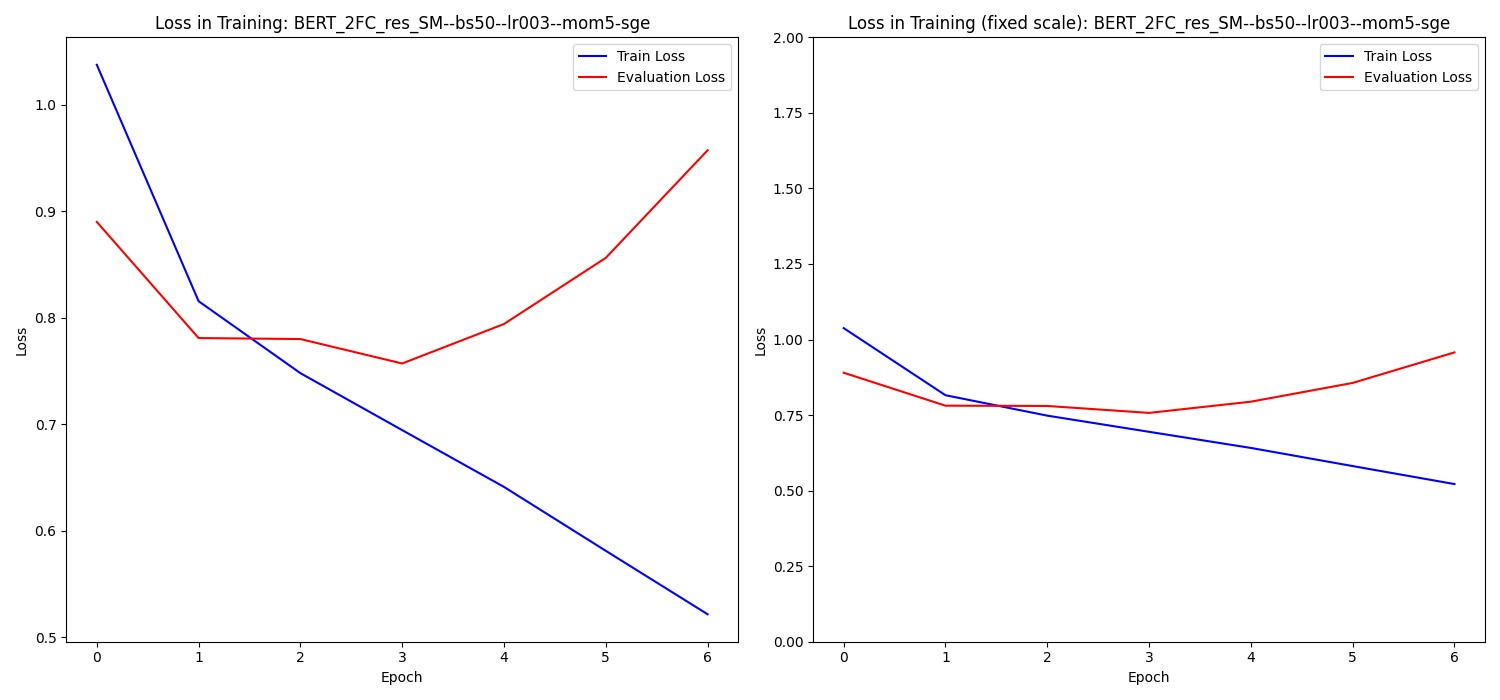

## 3.2 Trainings-Hyperparameter Tuning

Da alle vorher geschilderten Architekturen zu Overfitting geführt haben, haben wir uns dazu entschieden vorerst das Netz ohne BERT-Layer zu trainieren. Dazu haben wir zu Beginn des Trainings jeweils bei allen Parameter im ersten Layer unseres Modell die Eigenschaft *requires_grad* auf *False* gesetzt. Zunächst aber haben wir, aber mit einem verkürzten Trainingsprozess das optimale Hyperparametersetting für das Training identifiziert. Das vorgehen dabei ist im folgenden Unterabschnitt beschrieben.

Zusammenfassend kann man aber sagen, dass die Einstellungen der Hyperparameter nicht von herausragender Bedeutung waren. In der folgenden Zusammenfassenden Grafik, ebenfalls von Tensorbaord kopiert, sieht man, dass fast alle Versuche zu einem sehr ähnlichen Trainingsverlauf führen.

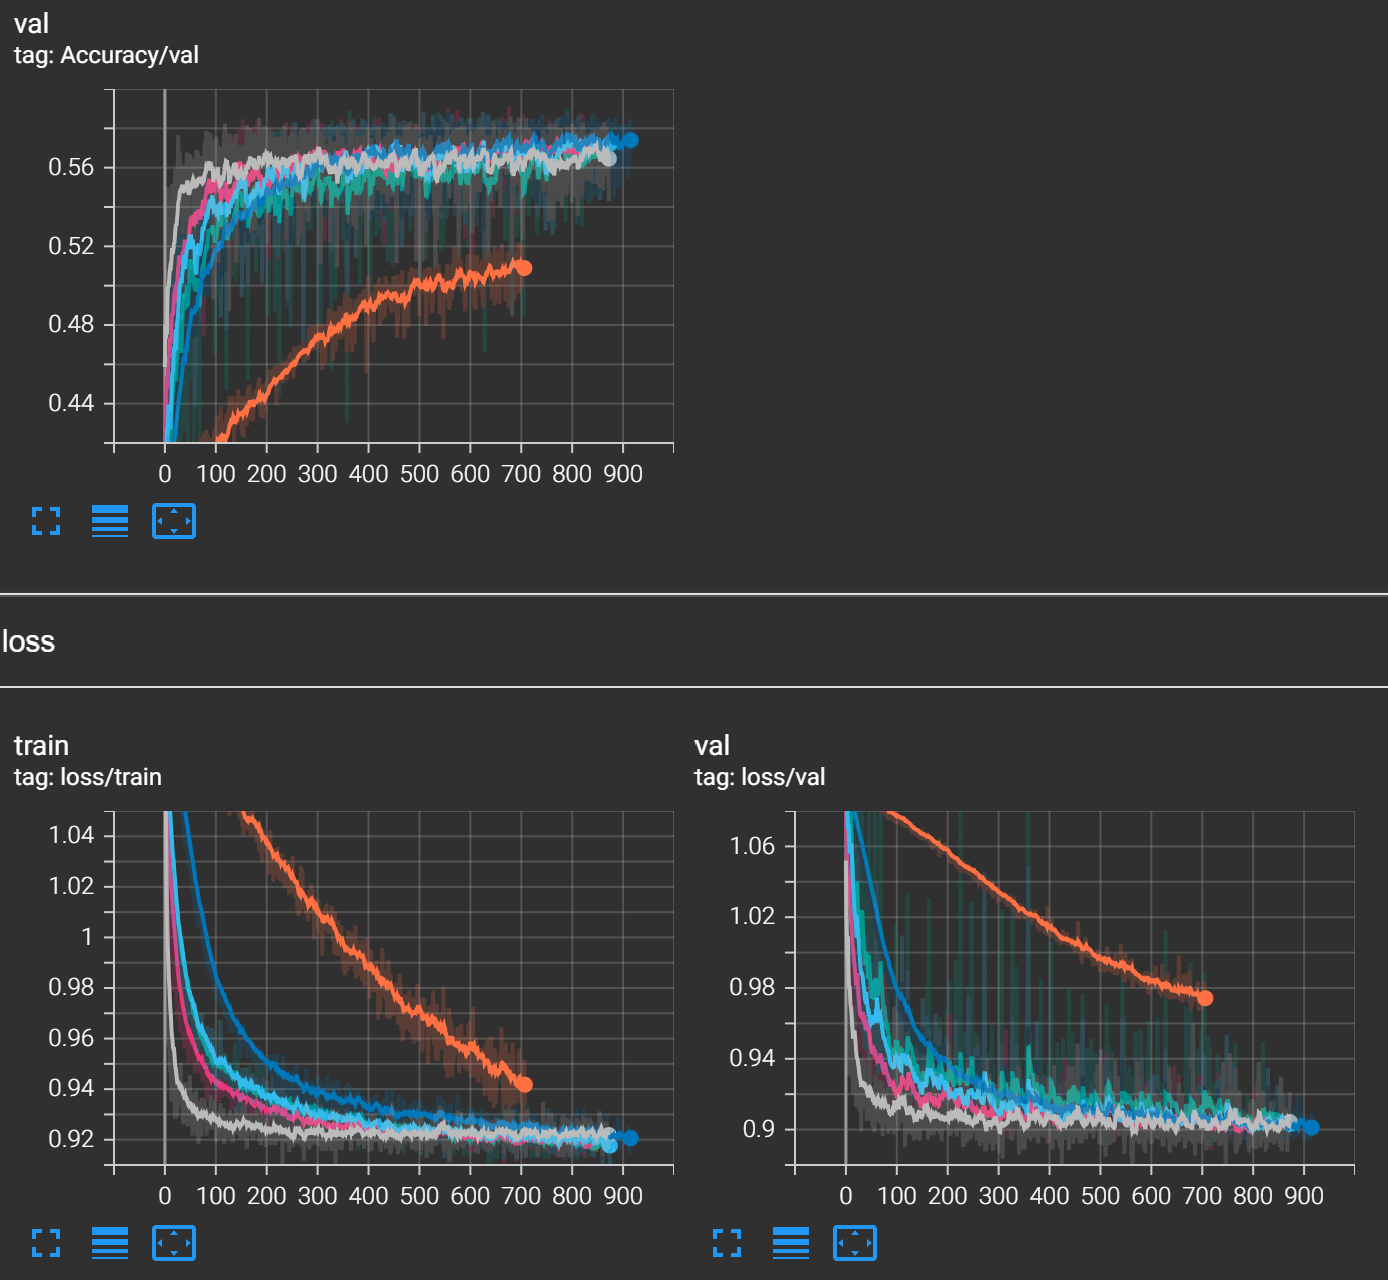

### 3.2.1 Vorgehen beim Hyperparameter Tuning

Um den Trainingsprozess zu beschleuigen, das Training und das Netz in zwei Teile geteilt. Wir haben zunächst alle Samples in ein Modell gespeist, dass nur den vortrainierten BERT-Layer enthalten hat. Die Outputs haben wir dann als neue Datasets gespeichert. Zum Ausprobieren verschiedener Hyperparameter haben wir dann reine Klassifizierungsarchitekturen auf dem neuerzeugen Datensatz trainiert.

Außerdem hat uns das die Möglichkeit gegeben die Daten einmal zu visualisieren. Unten Visualisieren wird die Daten im Latent-Space, also die Outputs des BERT-Layer. Da der Raum, in dem die Daten liegen, entsprechend der Anzahl der Output-Knoten des BERT-Layer 768 Dimensionen hat, haben wir eine Dimensionsreduktion vorgenommen. Hier haben wir dazu eine PCA genutzt.

In [ ]:
from models.bert_without_mlp import BERTClass_without_mlp
from torch import cuda
from data.datasets import dataset as dataset
from torch.utils.data import DataLoader

In [ ]:
def preprocess_first_layer(path_sets, file_path):
  with torch.no_grad():
    device = 'cuda' if cuda.is_available() else 'cpu'

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BERTClass_without_mlp()
    model.to(device)

    path = os.path.join(path_sets, file_path)
    data = pd.read_csv(path, delimiter=";")
    data = data.reset_index(drop=True)

    dataset_params = {
            'onehot': True,
            'onehot_encoding': [-1, 0, 1],
            'tokenize_bert': True,
            'max_len': 200,
            'tokenizer': tokenizer
        }

    dataset_tmp = dataset(data["Phrase"], data["Sentiment"], **dataset_params)


    # Dataloader initialisieren mit Datasets
    loader = DataLoader(dataset_tmp, batch_size=1)

    outputs_bert = []
    for _, batchdata in enumerate(loader):
      outputs_bert.append(model(batchdata, device).tolist()[0])

    outputs_bert = np.array(outputs_bert)
    dataset_after_first_layer = dataset(outputs_bert,
            data["Sentiment"],
            tokenize_bert=False,
            onehot=True,
            onehot_encoding = [-1, 0, 1],
            second_layer=True)
    dataset_after_first_layer[3]

    return dataset_after_first_layer

In [ ]:
path_sets = "./data/dataset_mr"


for ds in os.listdir(path_sets):
  if ("complete" not in ds):
    dataset_after_first_layer = preprocess_first_layer(path_sets, ds)
    new_path = "data/dataset_mr_after_first_layer/" + ds.split('.')[0] + ".pt"
    torch.save(dataset_after_first_layer, new_path)
    print(ds.split('.')[0] + " saved")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: ignored

In [ ]:
path_sets = "./data/dataset_mr"
train_file = "Trainset_complete.csv"

dataset_after_first_layer = preprocess_first_layer(path_sets, train_file)
new_path = "data/dataset_mr_after_first_layer/" + train_file.split('.')[0] + ".pt"
torch.save(dataset_after_first_layer, new_path)
print(train_file.split('.')[0] + " saved")


In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

ds = torch.load("data/dataset_mr_after_first_layer/Trainset_complete.pt")

# Daten für UMAP extrahieren
input_data = [item['input'].tolist() for item in ds]
targets_data = [item['targets'] for item in ds]


reducer = PCA(n_components=2)
embedding = reducer.fit_transform(input_data)

# Scatterplot erstellen
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[torch.argmax(x)] for x in targets_data],
    s=2)
ax.set_ylim(auto=True)
ax.set_xlim(auto=True)
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA-Projektion des Datensatzes', fontsize=24)
plt.show()

### 3.2.2 Gesamter vs. geteilter Datensatz

Die erste und wichtigste Erkenntnis ist, dass die Trainingskurve deutlich abgeflacht ist, wenn man die Trainingsstrategie verfolgt, die wir unsprünglich angedacht hatten, sprich 6 Trainingsdatensätze nacheinander rundum für je eine Epoche nutzen. Nachdem wir die Hardware-Limitation durch das Speichern der Zwischenergebnise gelöst hatten, konnten wir problemlos auf dem Gesamten Datensatz trainieren. Auch konnten wir später beim richtigen Training des Gesamten Netzes feststellen, dass die Hardware-Limitation primär durch die Batchsize entsteht und nicht durch die größe des initialen Datensatzes.

Der folgenden Grafik kann man entnehmen, dass das Training auf dem gesamten Datensatz deutlich schneller konvergiert als, die geteilte Variante.

Zu sehen ist:
* in orange: Training mit 6 Trainingsdatensätzen
* in blau: Training mit einem Trainingsdatensatz

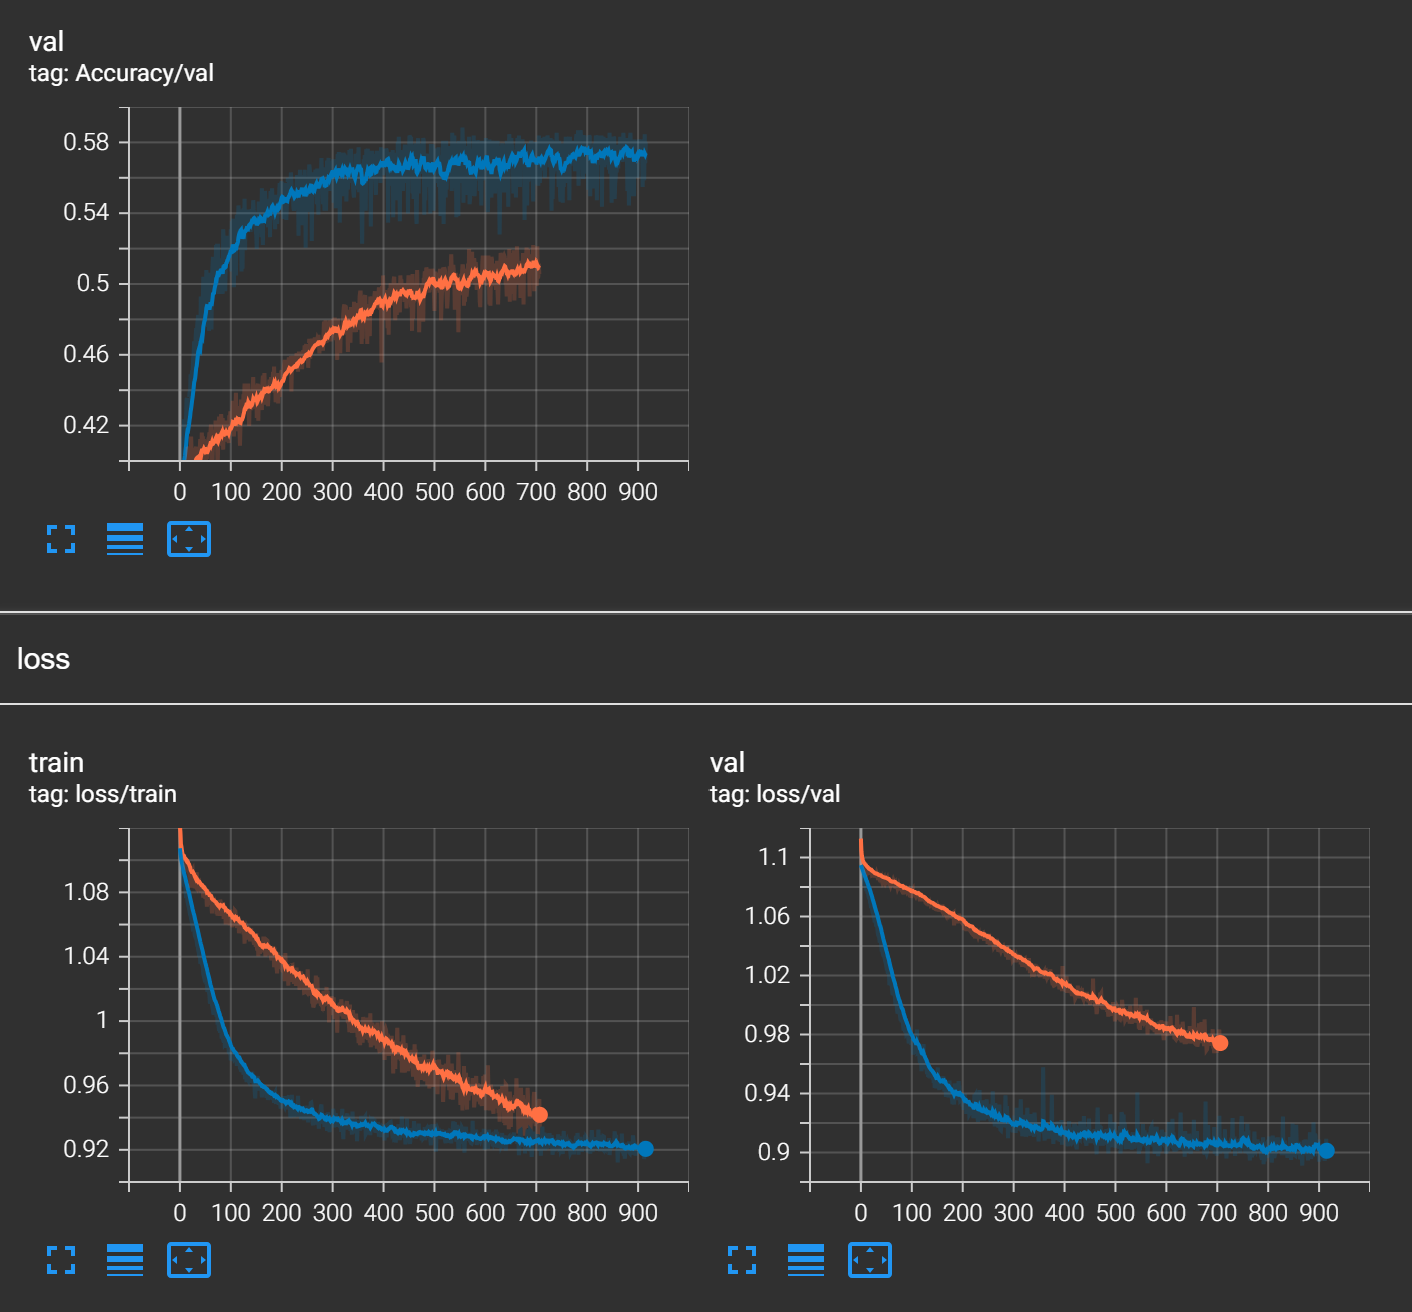

### 3.2.4 Optimizer: SGD

Bei der Anpassung der Parameter eines Neuronalen Netzes basierend auf den Gradienten gibt es verschiedene Anpassungsstrategien. Die üblichen Optimierungsarten sind SGE und ADAM. SGD steht für Statistical Gradient Descent. Bei dieser Methode ist eine fest Lernrate sowie ein Momentum definiert.

Die Lernrate wird mit dem Gradienten multipliziert, bevor dieser von dem jeweiligen Parameter zur Optimierung abgezogen wird. Kleinere Lernraten sollen verhindern, dass beim Optimieren der Parameter über das Optimum gesprungen wird.

Das Momentum definiert einen Anteil, zudem das Gradient aus dem vorherigen Schritt in den neuen Gradienten eingerechnet werden. Dies soll bewirken, dass die Optimierung weniger stark von lokalen Minima beeinflusst wird, sondern dem allgemeinen Trend folgt und möglichst ein globales Minimum erreicht.

Im Standardfall wird jedes Sample das Gradient berechnet. Wir nutzen hier Mini-Batch Gradient Descent. Dies erfolgt nach dem gleichen Prinzip nur, dass die Gradienten durch den Forward Pass einer gesamten Batch berechnet werden. [4]

Eine Steigerung der Lernrate hat bei unserem Modell wir auch allgemein zu erwarten ist, bewirkt, dass das Training schneller abläuft aber auch instabiler wird. In der folgenden Grafik sind 3 Trainingsdurchläufe zu sehen, bei denen wir die Lernrate je um eine zehnerpotenz gesteigert haben:

* dunkelblau: lr = 0.003
* hellblau: lr = 0.03
* tbd

In [ ]:
#TODO: lr=0.3 und Quelle

## 3.3 Optimierung Modellarchitektur

Nachdem wir ein zufriedenstellendes Trainingshyperparametersetting festgelegt hatten, haben wir als nächsten die Modellarchitektur des Klassifizierers nach dem BERT-Layer soweit es geht optimiert. Denn bei den verschiedenen Hyperparametersetting kann man erkennen, dass die resultierende Performance durch die Hyperparameter nicht verbessert wurde. Daher haben wir zunächst weiterhin auf den Output-Daten des BERT-Layer mehrere uns bekannte Architekturen ausprobiert.

### 3.3.1 Residual Layer

Oben haben wir bereits das Prinzip von Residual Layern beschrieben. Unsere Idee war durch das Einbauen von Residual Layern das Netz tiefer zu machen und dadurch mehr Komplexität abzubilden. Sowohl mit zwei als auch mit nur einem Residual Layer ist es jedoch zum Overfitting gekommen. Auch unter Anwendung von Batch-Normalisation in Kombination mit Layer-Normalisation hat sich dies kaum verbessert. Bei der Layer-Normalisation werden die Werte eines Forward Passes in einer Schicht über alle Knoten normalisiert.

### 1.2.x Modell Tuning (Classification Layer)

- Layer normalization
- Batch normalization
- Residual Layer
- Resigual Layer mit Bottleneck
- tbd: MSE


### 1.2.x Training auf Quadriga

- Vortraining Classification Layer

## 1.3 Fine Tuning Gesamtmodell


Nachdem wir eine hinreichend gute Modell-Architektur ermittelt haben, haben wir diese Architektur in einem vollständigen Modell mit dem vortrainierten BERT-Layer als ersten Layer trainiert. Als erstes haben wir dazu den ersten Layer beim Training eingefrohren und zunächst nur die Parameter des Klassifizierungsnetzwerkes trainiert. Der Trainingsverlauf ist im folgenden zusehen. Außerdem auch die Modellbewertung anhand des Testsets mit den Metriken, die wir bereits im Notebook zu den klassischen Verfahren vorgestellt haben.

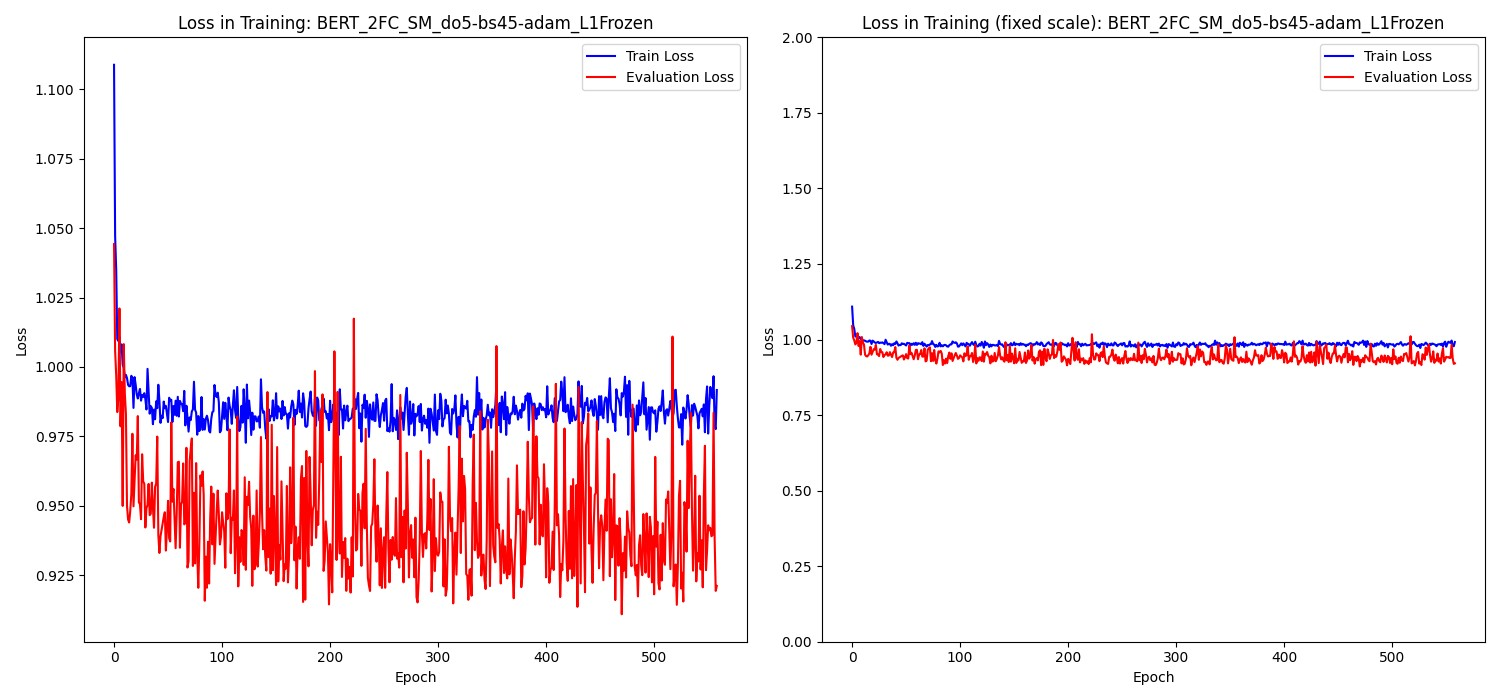

[MAIN]: Loading criterion
Test-Loss: 0.9089899659156799


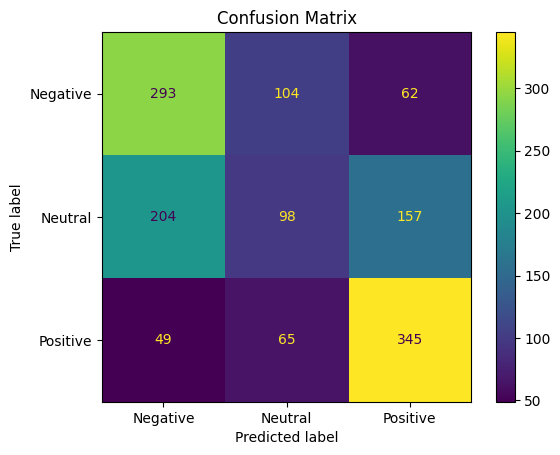

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.64      0.58       459
     Neutral       0.37      0.21      0.27       459
    Positive       0.61      0.75      0.67       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.51      1377
weighted avg       0.51      0.53      0.51      1377



0.5344952795933188

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_mr/Testset.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_BERT_2FC_SM_do5-bs45-adam_L1Frozen.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

Anschließend haben wir erneut versucht, dieses Modell weiter zu optimieren, weil das Ergebnis 53% Accuracy noch nicht sehr befriedigend war. Wir hatten überlegt, dass es eventuell zu weniger starkem Overfitting kommt, wenn der Klassifizierungslayer bereits trainiert ist und wir das Gesamtmodell danach weiter optimieren. Unsere These stelle sich als falsch heraus. Wie man auf dem folgendem Chart deutlich sehen kann, kam es auch hier bereits nach einer Epoche zum Overfitting.

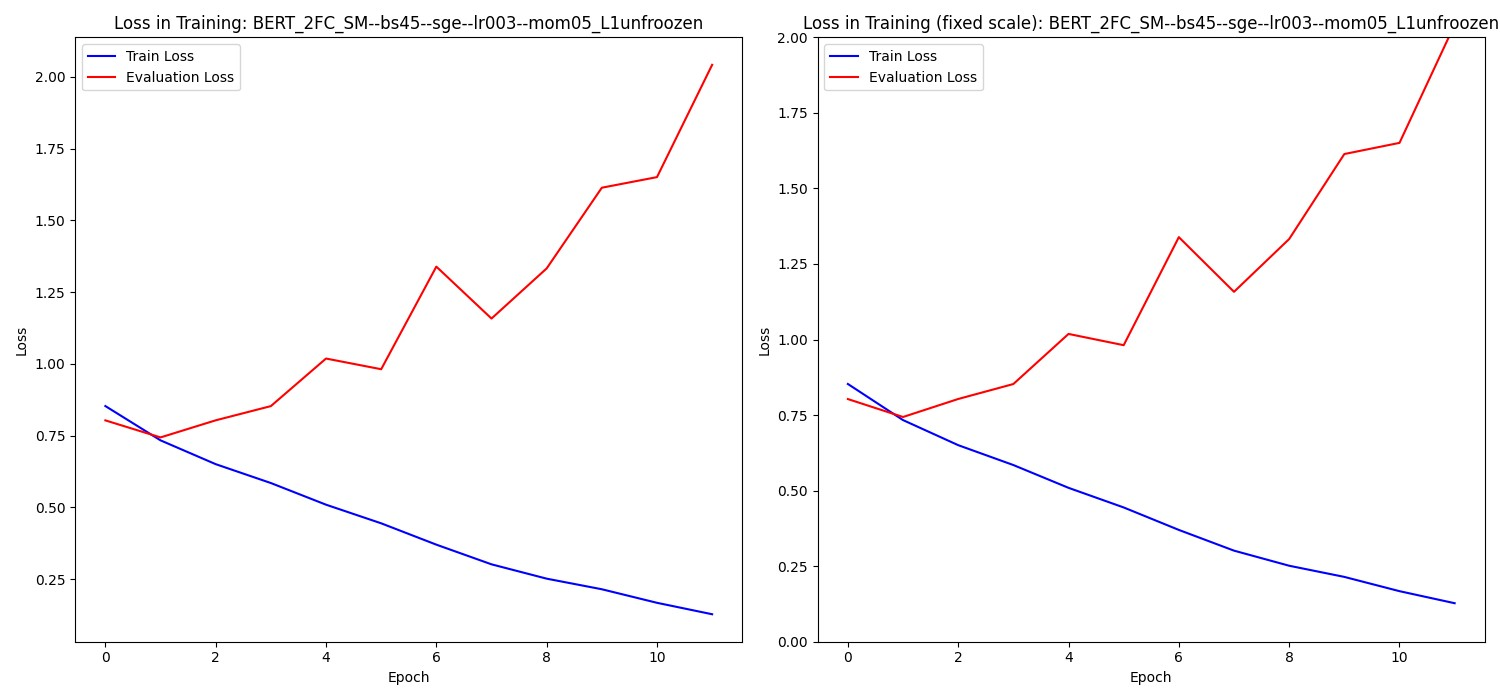

Man sieht aber auch, dass sich das Modell in der ersten Epoche noch verbessert. Daher haben wir eine unorthodoxe Technik angewendet, um trotzdem ein besseres Modell zu erhalten. Wir haben die Learning Rate herabgesetzt auf 0.0003, haben das Training live überwacht und in dem Moment gestoppt, wo wir das Optimum vermutet haben. So konnten wir die Accuracy auf 61% verbessern.

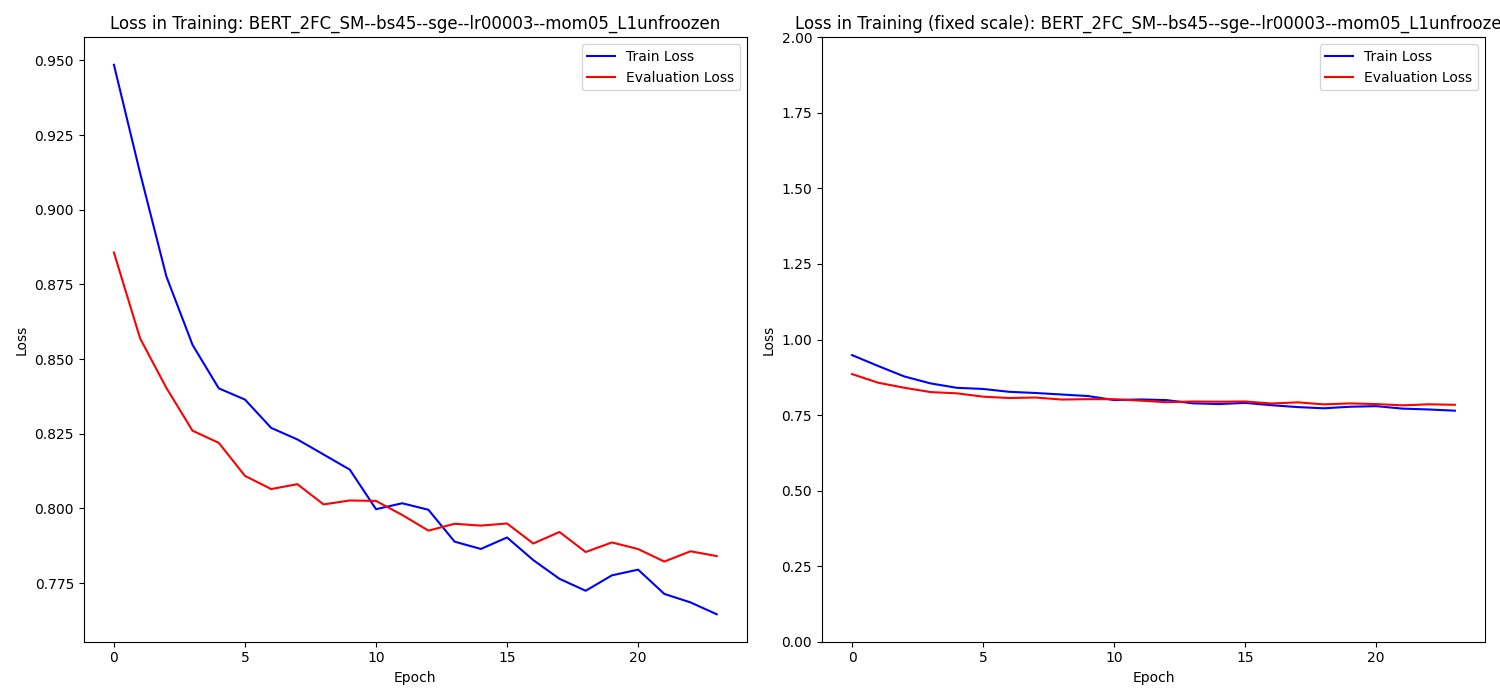

[MAIN]: Loading criterion
Test-Loss: 0.780398964881897


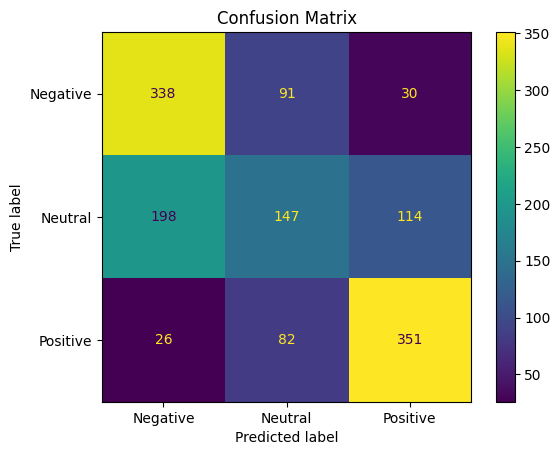

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.60      0.74      0.66       459
     Neutral       0.46      0.32      0.38       459
    Positive       0.71      0.76      0.74       459

    accuracy                           0.61      1377
   macro avg       0.59      0.61      0.59      1377
weighted avg       0.59      0.61      0.59      1377



0.6071169208424111

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_mr/Testset.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_BERT_2FC_SM--bs45--sge--lr00003--mom05_L1unfroozen.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

### 3.4 Amazon Datensatz

Da wir eine Vielzahl an Hyperparameterkombinationen und Modellarchitekturen für das Training mt dem Movie Review Datensatz ausprobiert haben, sind wir zu dem Schluss gekommen, dass das Modell schlicht zu tief ist bzw. der Datensatz zu klein ist, um ein gesamtes Bert-Modell sinnvoll zu trainieren. Daher haben wir uns von dem Training auf dem deutlich größeren Tweetsdatensatz eine deutlich bessere Performance erwartet und auch, dass das es nicht zum Overfitting kommt, auch wenn man alle Parameter trainiert. Wir haben beide Varianten ausprobiert. Ein Verlaufschart von de

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_tw/Testset.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_tw__BERT_2FC_do5_SM--bs45--adam_1froozen.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)